In [2]:
import numpy as np
import scipy.integrate as nint
from matplotlib import pyplot as plt
from plot_styler import style_plots
style_plots()

# circle

In [73]:
def circle_constraint(x):
    return 0.5 * (np.dot(x, x) - 1)


def circle_constraint_dt(x, xdot):
    return np.dot(x, xdot)


def lagrange_multiplier(x, xdot, f, m):
    return (
        -np.dot(f, x) - m * np.dot(xdot, xdot)
        - 1.0 * circle_constraint(x)
        - 1.0 * circle_constraint_dt(x, xdot)
    ) / (np.dot(x, x))


def net_force(x, xdot, f, **kwargs):
    return lagrange_multiplier(x, xdot, f, **kwargs) * x + f

In [84]:
def y_to_xv(y):
    return y[:len(y)//2], y[len(y)//2:]

def xv_to_y(x, xdot):
    return np.hstack([x, xdot])


def force(x, m):
    return np.array([0, -m * 1.0])
    #return np.zeros_like(x)


def ode_y(t, y, m):
    x, xdot = y_to_xv(y)
    dx = xdot
    dxdot = net_force(x, xdot, force(x, m), m=m) / m
    return xv_to_y(dx, dxdot)
    

t_range = np.linspace(0, 20, 100)
sol = nint.solve_ivp(ode_y,
            y0=xv_to_y(np.array([1, 0.0]), np.array([0, 1.0])),
            t_span=(t_range[0], t_range[-1]),
            t_eval = t_range,
            args=(1.0,),
            dense_output=True
)

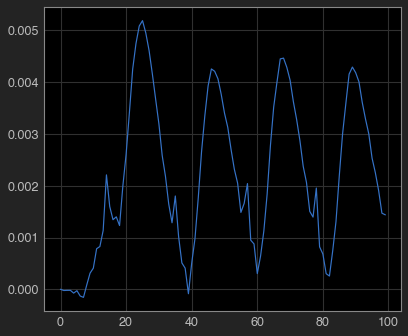

In [85]:
plt.plot((sol.y[0,:]**2 + sol.y[1,:]**2) - 1)

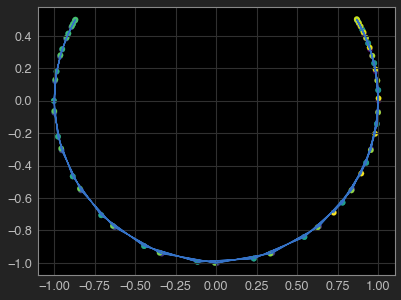

In [86]:
plt.plot(sol.y[0,:], sol.y[1,:])
plt.scatter(sol.y[0,:], sol.y[1,:], c=t_range)
plt.gca().set_aspect(1)

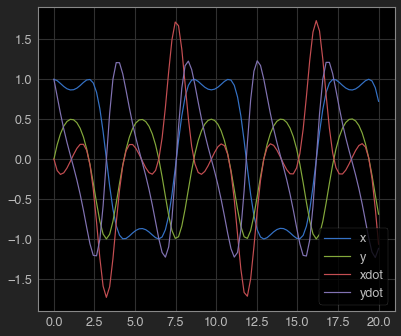

In [87]:
plt.plot(t_range, sol.y.T, label=['x','y','xdot','ydot'])
plt.legend()

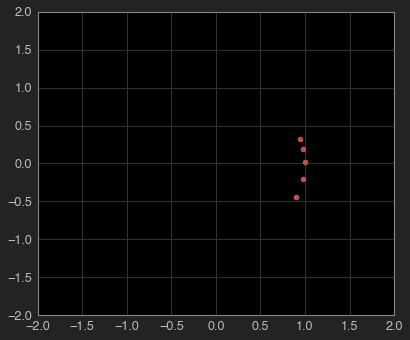

In [104]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = plt.plot([], [], 'ro')
n_plot_points = 5

def init():
    ax.set_xlim(-2,2)
    ax.set_ylim(-2,2)
    return ln,

def update(frame):
    imin = max(frame - n_plot_points, 0)
    ln.set_data(sol.y[0, imin:frame], sol.y[1, imin:frame])
    return ln,

ani = FuncAnimation(fig, update, frames=np.arange(sol.y.shape[1]),
                    init_func=init, blit=True)
HTML(ani.to_html5_video())

# general case

## definitions

In [674]:
import scipy.linalg as lin
from dataclasses import dataclass
from abc import ABC, abstractmethod
from typing import List

@dataclass
class ParticleSystem:
    dim: int
    n_particles: int
    
    def y_to_q(self, y):
        return y[:len(y)//2]

    def y_to_qdot(self, y):
        return y[len(y)//2:]

    def y_to_qqdot(self, y):
        return y_to_q(y), y_to_qdot(y)

    def qqdot_to_y(self, x, xdot):
        return np.hstack([x, xdot])

    def q_to_xs(self, q):
        return q.reshape(-1, self.dim)

    def xs_to_q(self, xs):
        return xs.ravel()
    

@dataclass
class Constraint(ABC):
    ps: ParticleSystem
    
    @abstractmethod
    def constraint(self, q):
        pass
    def constraint_dt(self, q, qdot):
        return np.dot(self.constraint_jac(q), qdot)
    @abstractmethod
    def constraint_jac(self, q):
        pass
    @abstractmethod
    def constraint_jac_dt(self, q, qdot):
        pass
    
@dataclass
class ConstraintMapper(Constraint):
    constraints: List[Constraint]
    
    def map_constraints(self, f, q, qdot=None):
        return np.array([f(c)(q) if qdot is None else f(c)(q, qdot) for c in self.constraints])

    def constraint(self, q):
        return self.map_constraints(lambda c: c.constraint, q)
    
    # todo need to differentiate each constraint by each qj (dc_i/d_qj)
    # to get a N_constraints x  (N_particles * N_dims) matrix
    # the number of constraints M and number of particles may be different
    def constraint_jac(self, q):
        return self.map_constraints(lambda c: c.constraint_jac, q)

    def constraint_jac_dt(self, q, qdot):
        return self.map_constraints(lambda c: c.constraint_jac_dt, q, qdot)

@dataclass
class SingleParticleConstraint(Constraint):
    apply_to: int
    
    def apply_to_particle(self, f, q):
        return f(self.ps.q_to_xs(q)[self.apply_to])
    
    def apply_to_particle_vec(self, f, q):
        return self.ps.xs_to_q(np.array([
            f(x) if i == self.apply_to else np.zeros_like(x)
            for i, x in enumerate(self.ps.q_to_xs(q))
        ]))
    
@dataclass
class MultipleParticleConstraint(Constraint):
    apply_to: List[int]
    
    def get_particles(self, q):
        return self.ps.q_to_xs(q)[self.apply_to]
    
    def apply_to_particles(self, f, q):
        return f(self.get_particles(q))
    
    def apply_to_particles_vec(self, fs, q):
        f_iter = iter(fs)
        xs = self.get_particles(q)
        return self.ps.xs_to_q(np.array([
            next(f_iter)(xs) if i in self.apply_to else np.zeros([self.ps.dim])
            for i in range(self.ps.n_particles)
        ]))


@dataclass
class CircleConstraint(SingleParticleConstraint):
    origin: np.ndarray
    radius: float
    
    def delta_x(self, x):
        return x - self.origin
    
    def constraint(self, q) -> float:
        return self.apply_to_particle(self.particle_constraint, q)
    
    def particle_constraint(self, x) -> float:
        return 0.5 * ((lambda xr: np.dot(xr, xr))(self.delta_x(x)) - self.radius**2)
    
    def constraint_jac(self, q):
        return self.apply_to_particle_vec(self.delta_x, q)
    
    def constraint_jac_dt(self, q, qdot):
        return self.apply_to_particle_vec(lambda x: x, qdot)


@dataclass
class CoupledCircleConstraint(MultipleParticleConstraint):
    """
    Particle 0 sets the origin of the circle
    Particle 1 is constrained to the circle
    """
    radius: float
    
    def delta_x(self, xs):
        return self.on_circle_x(xs) - self.origin(xs)
    
    def origin(self, xs):
        return xs[0]
    
    def on_circle_x(self, xs):
        return xs[1]
    
    def constraint(self, q) -> float:
        return self.apply_to_particles(self.circle_constraint, q)
    
    def circle_constraint(self, xs) -> float:
        return 0.5 * ((lambda xr: np.dot(xr, xr))(self.delta_x(xs)) - self.radius**2)
    
    def constraint_jac(self, q):
        #print(self.delta_x(self.ps.q_to_xs(q)))
        return self.apply_to_particles_vec([lambda xs: -self.delta_x(xs),self.delta_x], q)
    
    def constraint_jac_dt(self, q, qdot):
        return self.apply_to_particles_vec([lambda xdots: -self.delta_x(xdots), self.delta_x], qdot)
    
# todo try hanging a pendulum on the mass
# is there any accounting for the reaction force  on the mass?


def inverse_mass(q, m):
    return np.diag(np.repeat(1/m, len(q) // len(m)))


def force(q, m):
    return np.kron(m, -np.eye(len(q) // len(m))[1])


def lagrange_multiplier(constraint_mapper: ConstraintMapper, q, qdot, f, m):
    J = constraint_mapper.constraint_jac(q)
    W = inverse_mass(q, m)
    #print(J)
    JW = np.dot(J, W)
    A = np.dot(JW, J.T)
    
    #return J, W, constraint_jac_dt(q, qdot), force(q, m)
    b = (
        -np.dot(constraint_mapper.constraint_jac_dt(q, qdot), qdot)
        -np.dot(JW, f)
        - 1.0 * constraint_mapper.constraint(q) - 1.0 * constraint_mapper.constraint_dt(q, qdot)
    )
    #return J, A, b, np.linalg.cond(A)
    #return lin.solve(A, b)
    return lin.lstsq(A, b)[0]


def net_acceleration(constraint_mapper, q, qdot, f, m):
    J = constraint_mapper.constraint_jac(q)
    W = inverse_mass(q, m)
    f_constraint = np.dot(J.T, lagrange_multiplier(constraint_mapper, q, qdot, f, m))
    return np.dot(W, f + f_constraint)

In [431]:
net_acceleration(constraint_mapper, y0[:4], y0[4:], force(y0[:4], masses), masses)

array([-1.        , -1.        , -0.33333333, -1.        ])

## test

single particle on circle

In [497]:
masses = np.array([1.0])
q0 = xs_to_q(np.array([
        [1, 0.0]
    ]))
qdot0 = xs_to_q(np.array([
        [0, 1.0]
    ]))
y0 = qqdot_to_y(q0, qdot0)
particle_system = ParticleSystem(dim=2, n_particles=1)
constraints = [CircleConstraint(origin=np.array([0.0, 0.0]), radius=1, apply_to=0, ps=particle_system)]
constraint_mapper = ConstraintMapper(constraints=constraints, ps=particle_system)
print(
    lagrange_multiplier(constraint_mapper, q0, qdot0, force(q0, masses), masses)
)
print(
    net_acceleration(constraint_mapper, q0, qdot0, force(q0, masses), masses)
)

[-1.]
[-1. -1.]


two particles on circles

In [652]:
masses = np.array([1.0, 1.0])
q0 = xs_to_q(np.array([
        [1, 0.0],
        [4, 0.0]
    ]))
qdot0 = xs_to_q(np.array([
        [0, 1.0],
        [0, 1.0]
    ]))
y0 = qqdot_to_y(q0, qdot0)
particle_system = ParticleSystem(dim=2, n_particles=2)
constraints = [
    CircleConstraint(origin=np.array([0.0, 0.0]), radius=1, apply_to=0, ps=particle_system),
    CircleConstraint(origin=np.array([1.0, 0.0]), radius=3, apply_to=1, ps=particle_system)
]
constraint_mapper = ConstraintMapper(constraints=constraints, ps=particle_system)
print(
    lagrange_multiplier(constraint_mapper, q0, qdot0, force(q0, masses), masses)
)
# print(
#     net_acceleration(constraint_mapper, q0, qdot0, force(q0, masses), masses)
# )

[-1.         -0.11111111]


coupled particles

In [657]:
particle_system = ParticleSystem(dim=2, n_particles=2)
masses = np.array([1.0, 1.0])
q0 = xs_to_q(np.array([
        [3, 0.0],
        [4, 0.0]
    ]))
qdot0 = xs_to_q(np.array([
        [0, 0.0],
        [0, 0.0]
    ]))
y0 = qqdot_to_y(q0, qdot0)
#y0 = sol.y[:,17]
#q0, qdot0 = particle_system.y_to_qqdot(y0)
constraints = [
    CircleConstraint(origin=np.array([0.0, 0.0]), radius=3, apply_to=0, ps=particle_system),
    CoupledCircleConstraint(radius=1, apply_to=[0,1], ps=particle_system),
]
constraint_mapper = ConstraintMapper(constraints=constraints, ps=particle_system)
print(
    lagrange_multiplier(constraint_mapper, q0, qdot0, force(q0, masses), masses)
)
print(
    net_acceleration(constraint_mapper, q0, qdot0, force(q0, masses), masses)
)

[0. 0.]
[ 0. -1.  0. -1.]


more coupled particles

In [697]:
particle_system = ParticleSystem(dim=2, n_particles=4)
masses = np.array([1.0, 1.0, 1.0, 1.0])
q0 = xs_to_q(np.array([
        [3, 0.0],
        [4, 0.0],
        [5, 0.0],
        [6, 0.0],
    ]))
qdot0 = xs_to_q(np.array([
        [0, 0.0],
        [0, 0.0],
        [0, 0.0],
        [0, 0.0],
    ]))
y0 = qqdot_to_y(q0, qdot0)
#y0 = np.random.randn(12)
q0, qdot0 = particle_system.y_to_qqdot(y0)
constraints = [
    CircleConstraint(origin=np.array([0.0, 0.0]), radius=3, apply_to=0, ps=particle_system),
    CoupledCircleConstraint(radius=1, apply_to=[0,1], ps=particle_system),
    CoupledCircleConstraint(radius=1, apply_to=[1,2], ps=particle_system),
    CoupledCircleConstraint(radius=1, apply_to=[2,3], ps=particle_system)
]
constraint_mapper = ConstraintMapper(constraints=constraints, ps=particle_system)
print(
    lagrange_multiplier(constraint_mapper, q0, qdot0, force(q0, masses), masses)
)
print(
    net_acceleration(constraint_mapper, q0, qdot0, force(q0, masses), masses)
)

[0. 0. 0. 0.]
[ 0. -1.  0. -1.  0. -1.  0. -1.]


## solve ode

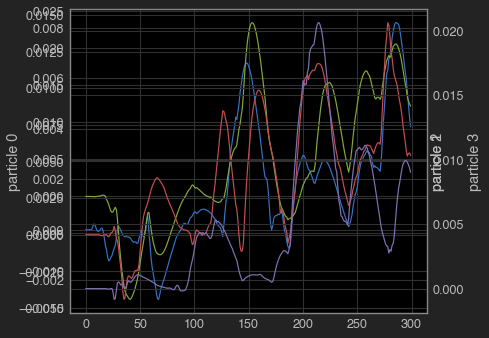

In [698]:



def ode_y(t, y, constraint_mapper, m):
    x, xdot = y_to_qqdot(y)
    dx = xdot
    dxdot = net_acceleration(constraint_mapper, x, xdot, force(x, m), m=m)
    return qqdot_to_y(dx, dxdot)

t_range = np.linspace(0, 30, 300)
# masses = np.array([1.0,1])
# q0 = xs_to_q(np.array([
#         [3, 0.0],
#         [4, 0.0]
#     ]))
# qdot0 = xs_to_q(np.array([
#         [0, 0.0],
#         [0, 0.0]
#     ]))
# y0 = qqdot_to_y(q0, qdot0)

# particle_system = ParticleSystem(dim=2, n_particles=2)
# constraints = [
#     CircleConstraint(origin=np.array([0.0, 0.0]), radius=3, apply_to=0, ps=particle_system),
#     CoupledCircleConstraint(radius=1, apply_to=[0,1], ps=particle_system),
# ]
# constraint_mapper = ConstraintMapper(constraints=constraints, ps=particle_system)


sol = nint.solve_ivp(ode_y,
            y0=y0,
            t_span=(t_range[0], t_range[-1]),
            t_eval = t_range,
            args=(constraint_mapper, masses),
            dense_output=True
)
#plt.plot(((sol.y[0,:] - 0)**2 + sol.y[1,:]**2) - 1)
#plt.plot(((sol.y[2,:] - sol.y[)**2 + sol.y[3,:]**2) - 9)
constraint_mapper.constraint(particle_system.y_to_q(y0))
constraint_values = np.array([constraint_mapper.constraint(particle_system.y_to_q(y)) for y in sol.y.T])

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, cv in enumerate(constraint_values.T):
    ax = plt.gca().twinx() if i > 0 else plt.gca()
    ax.plot(cv, c=colors[i])
    ax.set_ylabel(f'particle {i}')

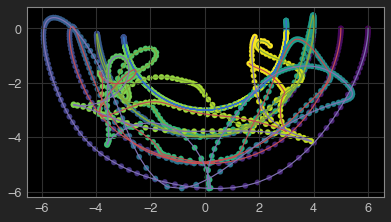

In [699]:
for x in np.array([
        particle_system.q_to_xs(particle_system.y_to_q(y)) for y in sol.y.T
]).transpose(1,0,2):
    plt.plot(x[:,0], x[:,1])
    plt.scatter(x[:,0], x[:,1], c=sol.t)
    plt.gca().set_aspect(1)

In [655]:
def energy(xs,xdots, ms):
    return sum(0.5 * m * np.dot(xdot, xdot) + m * x[1]  for x, xdot, m in zip(xs, xdots, ms))

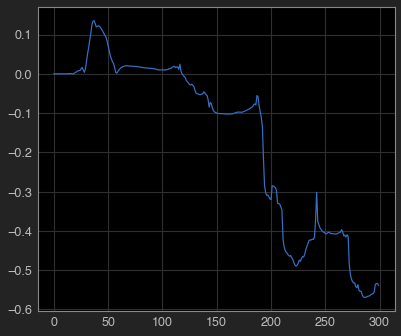

In [700]:
E_t = np.array([energy(*map(particle_system.q_to_xs,particle_system.y_to_qqdot(y)), masses) for y in sol.y.T])
plt.plot(E_t)

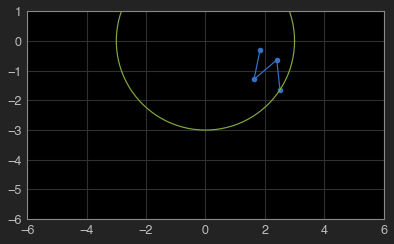

In [702]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots()
ax.set_aspect(1)
xdata, ydata = [], []
ln, = plt.plot([], [], marker='o')
(lambda x: plt.plot(3*np.cos(x),3*np.sin(x)))(np.linspace(0,np.pi*2,100))
n_plot_points = 5

def init():
    ax.set_xlim(-6,6)
    ax.set_ylim(-6,1)
    return ln,

def update(frame):
    imin = max(frame - n_plot_points, 0)
    ln.set_data(
        [sol.y[i*particle_system.dim, frame] for i in range(particle_system.n_particles)],
        [sol.y[i*particle_system.dim + 1, frame] for i in range(particle_system.n_particles)]
    )
    return ln,

ani = FuncAnimation(fig, update, frames=np.arange(sol.y.shape[1]),
                    init_func=init, blit=True, interval=33)
HTML(ani.to_html5_video())